In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
# datadir = "/content/drive/My Drive/cs445_projects/proj3/" 
datadir = "./" 

utilfn = datadir + "utils.py"

samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .
import utils

In [94]:
background_img = cv2.cvtColor(cv2.imread('samples/woman.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
# plt.figure()
# plt.imshow(background_img)
# plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/man.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
# object_img = object_img[100:250, 100:250, :]
# plt.imshow(object_img)
# plt.show()

In [95]:
def eye_detection(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.equalizeHist(image_gray)
    #-- Detect faces
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(image_gray, 1.03, 3)
#     plt.imshow(img)
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = image_gray[y:y+h,x:x+w]
        start = 5
        eyes = eye_cascade.detectMultiScale(faceROI, 1.03, 5)
        while eyes.shape[0] > 2:
            start +=5
            eyes = eye_cascade.detectMultiScale(faceROI, 1.03, start)
        print(eyes.shape)
        x1,y1,w1,h1 = eyes[0]
        x2,y2,w2,h2 = eyes[1]   
        eye1_center = (x + x1 + w1//2, y + y1 + h1//2)
        radius1 = int(round((w1 + h1)*0.25))
        img = cv2.circle(img, eye1_center, radius1, (255, 0, 0 ), 4)
        eye2_center = (x + x2 + w2//2, y + y2 + h2//2)
        radius2 = int(round((w2 + h2)*0.25))
        img = cv2.circle(img, eye2_center, radius2, (255, 0, 0 ), 4)
    plt.figure()
    result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    plt.imshow(result)
    #cv2.imshow('Capture - Face detection', img)
    eyes = np.array([[x + x1 + w1//2, y + y1 + h1//2], [x + x2 + w2//2, y + y2 + h2//2]])
    return eyes

(2, 4)


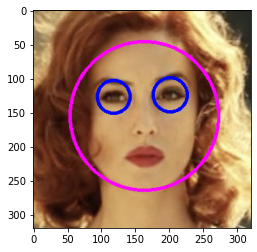

In [97]:
eye1_locations = eye_detection(cv2.imread('samples/woman.jpeg'))

(2, 4)


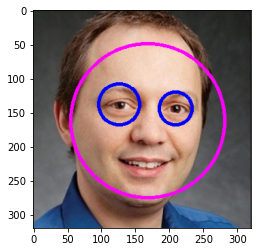

In [66]:
eye2_locations = eye_detection(cv2.imread('samples/man.jpeg'))

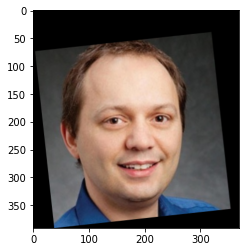

In [67]:
img1 = cv2.cvtColor(np.float32(cv2.imread('samples/woman.jpeg') / 255.0), cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(np.float32(cv2.imread('samples/man.jpeg') / 255.0), cv2.COLOR_BGR2RGB)


im1, im2 = utils.align_images(img2, img1, eye2_locations , eye1_locations,
                 save_images=True)

# cv2.imwrite('face1.jpeg', im1)
# cv2.imwrite('face2.jpeg', im2)

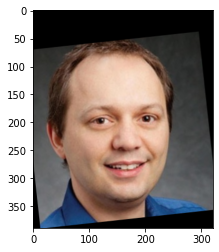

In [68]:
plt.imshow(im1)

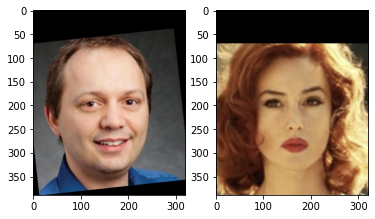

In [69]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[1].imshow(im2,cmap='gray')

In [70]:
cv2.imwrite("samples/face2.jpeg", im2*255)
cv2.imwrite("samples/face1.jpeg", im1*255)

True

(2, 4)
(2, 4)


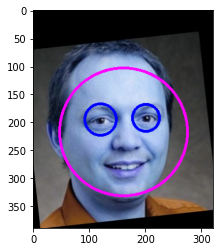

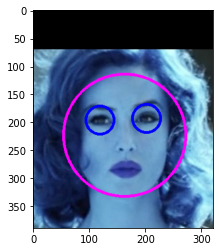

In [71]:
eye1 = eye_detection(cv2.imread('samples/face1.jpeg'))
eye2 = eye_detection(cv2.imread('samples/face2.jpeg'))

In [80]:
print(eye1)

[[201 192]
 [120 195]]


In [81]:
def compute_mask(eye_raw):
    eye = eye_raw.copy()
    if eye_raw[0][0] > eye_raw[1][0]:
        eye[0] = eye_raw[1]
        eye[1] = eye_raw[0]
        
    dis_x = eye[1][0] - eye[0][0]
    dis_y = eye[1][1] - eye[0][1]
    p1 = [eye[0][0] - 0.3*dis_x + 0.2*dis_y, eye[0][1] - 0.2*dis_x - 0.3*dis_y]
    p2 = [eye[1][0] + 0.3*dis_x + 0.2*dis_y, eye[0][1] - 0.2*dis_x + 0.3*dis_y]
    
    p3 = [eye[1][0] + 0.1*dis_x - 1.2*dis_y, eye[1][1] + 1.2*dis_x + 0.1*dis_y]
    p4 = [eye[0][0] - 0.1*dis_x - 1.2*dis_y, eye[0][1] + 1.2*dis_x - 0.1*dis_y]
    x_list = (p1[0], p2[0], p3[0], p4[0])
    y_list = (p1[1], p2[1], p3[1], p4[1])
    return x_list, y_list

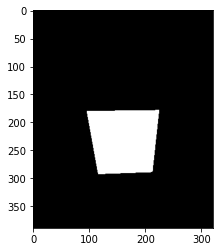

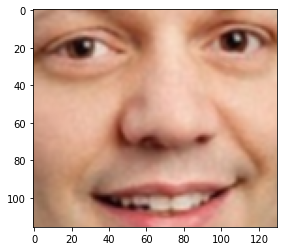

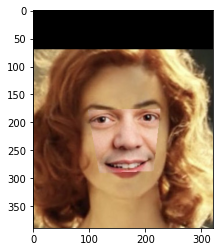

In [84]:
object_img = im1
background_img = im2

xs,ys = compute_mask(eye1)
# xs = (eye1[0][0]-29.2+1, eye1[1][0]+29.2+1, 201+8.4, 117-8.4)
# ys = (eye1[0][1]-1.5-16.8, eye1[1][1]+1.5-16.8, 282+0.5, 277+0.5)
object_mask = utils.get_mask(ys, xs, object_img)
bottom_center = (int((xs[2]+xs[3])/2), int((ys[2]+ys[3])/2)) # (x,y)

object_img, object_mask = utils.crop_object_img(object_img, object_mask)
bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    
plt.figure()
plt.imshow(object_img)

fig = plt.figure()
plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))


finish preprocess
poisson done
finish preprocess
poisson done
finish preprocess


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


poisson done


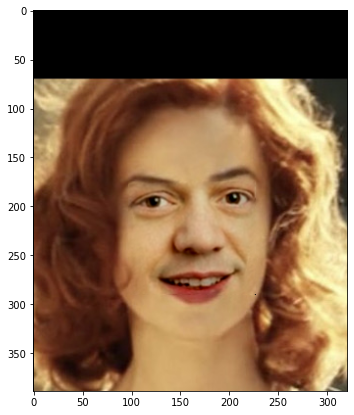

In [86]:
im_blend = np.zeros(background_img.shape)
temp = 0
for b in np.arange(3):
    im_blend[:,:,b] = utils.poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)


plt.figure(figsize=(7,7))
plt.imshow(im_blend)